In [40]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import sys
import os
#Perform the necessary pull of some helper functions.
import lmfit
from lmfit import Model
import scipy
import matplotlib
import matplotlib.pyplot as plt
# To match plot styles in the draft.
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.top']=True
plt.rcParams['ytick.right']=True
plt.rcParams['font.size']=10
plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10
plt.rcParams['text.usetex']=False
plt.rcParams['font.family']='serif'
%matplotlib inline
import bnrof
from mantid.simpleapi import *
import MDUtils as mdu
from bnrof import IEXY_data
from bnrof import Material
from mantid.geometry import CrystalStructure, ReflectionGenerator, ReflectionConditionFilter

## The first step in the analysis of the SEQUOIA data is the normalization to the available structural Bragg peaks. 

This is necessary to extract quantities like the total frozen / dynamic moment and exchange interaction estimates later. The theory behind this is described in the appendix of the main text. 

In [2]:
Alum = Material('Aluminum.cif',suppress_print=True,nist_data='nist_scattering_table.txt')
BNRO_mantid = CrystalStructure("5.75733 5.75733 28.58700","R -3 m", "Ba 0 0 0.12933 1.0 0.015;\
                                                                    Ba 0 0 0.28678 1.0 0.011;\
                                                                    Nb 0 0 0 1.0 0.004;\
                                                                    Ru 0 0 0.5 1.0 0.016;\
                                                                    Ru 0 0 0.4122 1.0 0.011;\
                                                                    O 0.4923 0.50770 0.12244 1.0 0.022;\
                                                                    O 0.50552 0.4945 0.29332 1.0 0.013")
BNRO_th = Material('Ba4NbRu3O12_refined-structure.cif',suppress_print=True)

Qslice50 = bnrof.genQslice(0,4,100)
Eslice50 = bnrof.genEslice(-50,50,100)


Qslice25 = bnrof.genQslice(0,4,100)
Eslice25 = bnrof.genEslice(-25,25,100)

Qslice10 = bnrof.genQslice(0,2.5,60)
Eslice10 = bnrof.genEslice(-10,10,40)

#Start importing data files. MT means empty can. 
lowT_MT_f10 = 'SEQ Data Files/MTCenterPos_10p50_4p04.nxspe'
highT_MT_f10 = 'SEQ Data Files/MTCenterPos_10p50_150p01.nxspe'
lowT_samp_f10 ='SEQ Data Files/CenterPos_10p50_3p98.nxspe'
highT_samp_f10 = 'SEQ Data Files/CenterPos_10p50_150p00.nxspe'

# nxspes without multiphonon
lowT_MT_f25 = 'SEQ Data Files/MTCenterPos_25p00_4p00.nxspe'
highT_MT_f25 = 'SEQ Data Files/MTCenterPos_25p00_300p00.nxspe'
lowT_samp_f25 ='SEQ Data Files/CenterPos_25p00_3p95.nxspe'
highT_samp_f25 = 'SEQ Data Files/CenterPos_25p00_300p11.nxspe'

lowT_MT_f50 = 'SEQ Data Files/MTCenterPos_50p00_4p30.nxspe'
highT_MT_f50 = 'SEQ Data Files/MTCenterPos_50p00_300p00.nxspe'
lowT_samp_f50 ='SEQ Data Files/CenterPos_50p00_4p22.nxspe'
highT_samp_f50 = 'SEQ Data Files/CenterPos_50p00_300p00.nxspe'

BNRO_mantid = CrystalStructure("5.75733 5.75733 28.58700","R -3 m", "Ba 0 0 0.12933 1.0 0.015;\
                                                                    Ba 0 0 0.28678 1.0 0.011;\
                                                                    Nb 0 0 0 1.0 0.004;\
                                                                    Ru 0 0 0.5 1.0 0.016;\
                                                                    Ru 0 0 0.4122 1.0 0.011;\
                                                                    O 0.4923 0.50770 0.12244 1.0 0.022;\
                                                                    O 0.50552 0.4945 0.29332 1.0 0.013")

BNRO_th.formula_units=3.0
BNRO=BNRO_th

MD_25_4 = bnrof.import_files_to_MD(lowT_samp_f25,MT_arr=lowT_MT_f25,Q_slice=Qslice25,\
                                        E_slice=Eslice25,self_shield=1.0,numEvNorm=True).clone()
MD_25_300 = bnrof.import_files_to_MD(highT_samp_f25,MT_arr=highT_MT_f25,Q_slice=Qslice25,\
                                          E_slice=Eslice25,self_shield=1.0,numEvNorm=True).clone()
MD_50_4 = bnrof.import_files_to_MD(lowT_samp_f50,MT_arr=lowT_MT_f50,Q_slice=Qslice50,\
                                        E_slice=Eslice50,self_shield=1.0,numEvNorm=True).clone()
MD_50_300 = bnrof.import_files_to_MD(highT_samp_f50,MT_arr=highT_MT_f50,Q_slice=Qslice50,\
                                          E_slice=Eslice50,self_shield=1.0,numEvNorm=True).clone()
MD_10_4 = bnrof.import_files_to_MD(lowT_samp_f10,MT_arr=lowT_MT_f10,Q_slice=Qslice10,\
                                     E_slice=Eslice10,self_shield=1.0,numEvNorm=True).clone()
MD_10_150 = bnrof.import_files_to_MD(highT_samp_f10,MT_arr=highT_MT_f10,Q_slice=Qslice10,\
                                      E_slice=Eslice10,self_shield=1.0,numEvNorm=True).clone()


d_eff = 0.5 #in cm
#Simple absorption model below using tabulated values. Assumes d_eff
# is the average neutron path and that the neutron energy is the geometric
# mean of the incoming and outgoing energies. In BRNO the attenuation is always
# very small, less than 5%. 
MD_abs_25_4 = bnrof.correct_absorb_MD_Material(MD_25_4,25.0,BNRO_th,d_eff,False).clone()
MD_abs_25_300 = bnrof.correct_absorb_MD_Material(MD_25_300,25.0,BNRO_th,d_eff,False).clone()

MD_abs_50_4 = bnrof.correct_absorb_MD_Material(MD_50_4,50.0,BNRO_th,d_eff,False).clone()
MD_abs_50_300 = bnrof.correct_absorb_MD_Material(MD_50_300,50.0,BNRO_th,d_eff,False).clone()

MD_abs_10_4 = bnrof.correct_absorb_MD_Material(MD_10_4,10.0,BNRO_th,d_eff,False).clone()
MD_abs_10_150 = bnrof.correct_absorb_MD_Material(MD_10_150,10.0,BNRO_th,d_eff,False).clone()

scale_list = []
measurement_list = [MD_abs_25_4,MD_abs_25_300,MD_abs_50_4,MD_abs_50_300,MD_abs_10_4,MD_abs_10_150]
#Plot each
Ei_list = [25.0,25.0,50.0,50.0,10.5,10.5]
fwhm_list=[1.4,1.4,3.0,3.0,0.6,0.6]
temp_list = [4.0,300.0,4.0,300.0,4.0,150.0]

#scale dict from manual normalizations:
correctscales = np.array([2.56e1,2.67e1,2.132e1,2.201e1,3.738e2,3.759e2])*10.0

for i in range(len(measurement_list)):
    md=measurement_list[i]
    Ei=Ei_list[i]
    energy_fwhm = fwhm_list[i]
    if Ei<11.5:
        bannedQ = [[0,0.5],[2.0,3.0]]
    elif Ei==25.0:
        bannedQ = [[0,0.5],[3.2,5.0]]
    else:
        bannedQ=[[0,0.5]]
    if i in [0]:
        pltresults=True
    else:
        pltresults=True
    datscale = bnrof.get_md_Material_bragg_normalization_factors(md,Ei,\
                                            Ei*0.05,BNRO_mantid,BNRO_th,aluminum_material=Alum,\
                                            scale_guess=5.0e2,peak_width_guess=0.025,alum_scale_guess=0.0,sample_mass=1.0,\
                                            allow_aluminum=False,banned_Q_regimes=[[0.0,1.0],[3.2,6.0]],fit_method='powell',\
                                            allow_q_shift=False,plot_results=pltresults,
                                            plot_savedir=f"SEQ_figs/SEQ_norm_Ei_{Ei:.2f}_T_{temp_list[i]:.2f}.pdf")
    scale_list.append(datscale['result_scale'])
    print(f"For Ei={Ei}, extracted scale={datscale['result_scale']:.2e}")
    print(f"Estimated Correct scale = {correctscales[i]:.2e}")

 Material.formula_weight=(val)
LoadNXSPE-[Notice] LoadNXSPE started
LoadNXSPE-[Notice] LoadNXSPE successful, Duration 0.06 seconds
LoadNXSPE-[Notice] LoadNXSPE started
LoadNXSPE-[Notice] LoadNXSPE successful, Duration 0.06 seconds
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace started
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace successful, Duration 0.00 seconds
Divide-[Notice] Divide started
Divide-[Notice] Divide successful, Duration 0.00 seconds
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace started
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace successful, Duration 0.00 seconds
Divide-[Notice] Divide started
Divide-[Notice] Divide successful, Duration 0.01 seconds
ConvertToMD-[Notice] ConvertToMD started
ConvertToMD-[Notice] ConvertToMD successful, Duration 0.04 seconds
ConvertToMD-[Notice] ConvertToMD started
ConvertToMD-[Notice] ConvertToMD successful, Duration 0.02 seconds
BinMD-[Notice] BinMD started
BinM

## Make initial plots of the scattering.

With applied corrections for absorption, normalization to Bragg peaks so scattering is now in absolute units.

In [3]:
%matplotlib inline

CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace started
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace successful, Duration 0.00 seconds
MultiplyMD-[Notice] MultiplyMD started
MultiplyMD-[Notice] MultiplyMD successful, Duration 0.00 seconds
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace started
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace successful, Duration 0.00 seconds
MultiplyMD-[Notice] MultiplyMD started
MultiplyMD-[Notice] MultiplyMD successful, Duration 0.00 seconds
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace started
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace successful, Duration 0.00 seconds
MultiplyMD-[Notice] MultiplyMD started
MultiplyMD-[Notice] MultiplyMD successful, Duration 0.00 seconds
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace started
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace successful, Duration 0.00 seconds


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


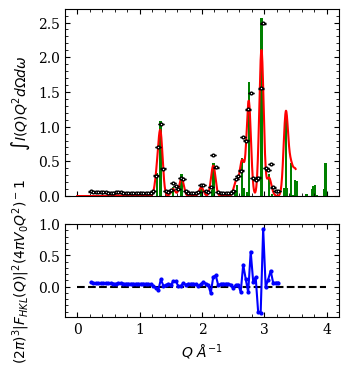

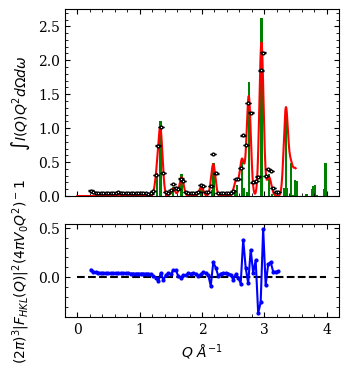

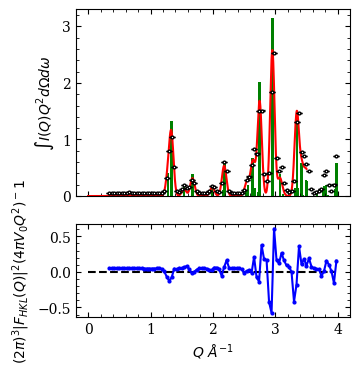

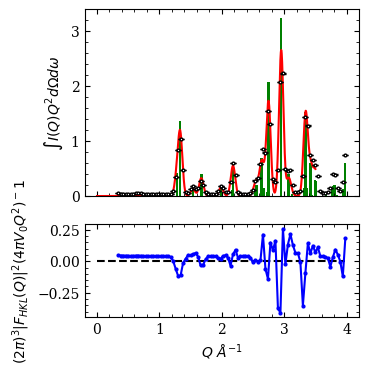

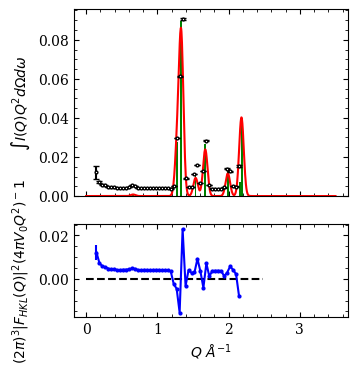

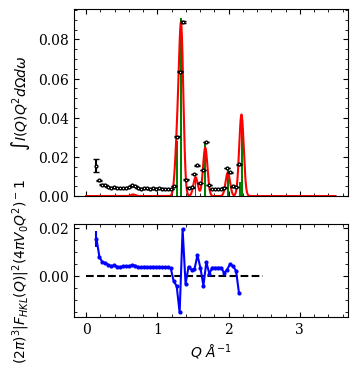

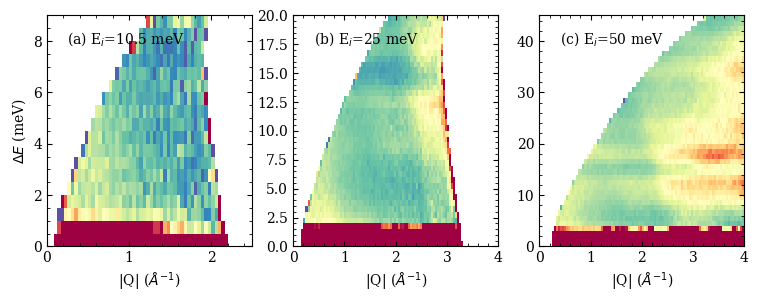

In [4]:
scale_25_4,scale_25_300,scale_50_4,scale_50_300,scale_10_4,scale_10_150 = scale_list
MD_abs_bragg_25_4 = MD_abs_25_4 * scale_25_4 
MD_abs_bragg_25_300 = MD_abs_25_300 * scale_25_300  
MD_abs_bragg_50_300 = MD_abs_50_300 * scale_50_300  
MD_abs_bragg_50_4 = MD_abs_50_4*scale_50_4
MD_abs_bragg_10_4 = MD_abs_10_4 * scale_10_4
MD_abs_bragg_10_150 = MD_abs_10_150 * scale_10_150

inel_50_5K = MD_abs_bragg_50_4.clone()
inel_50_300K = MD_abs_bragg_50_300.clone()
inel_25_5K = MD_abs_bragg_25_4.clone()
inel_25_300K = MD_abs_bragg_25_300.clone()
inel_10_5K = MD_abs_bragg_10_4.clone()
inel_10_150K = MD_abs_bragg_10_150.clone()

fig, ax = plt.subplots(1,3,subplot_kw={'projection':'mantid'},figsize=(9,3))
ax[0].pcolormesh(bnrof.undo_normalize_MDHisto_event(inel_10_5K),vmin=0,vmax=0.15,cmap='Spectral_r')
ax[1].pcolormesh(bnrof.undo_normalize_MDHisto_event(inel_25_5K),vmin=0,vmax=0.15,cmap='Spectral_r')
ax[2].pcolormesh(bnrof.undo_normalize_MDHisto_event(inel_50_5K),vmin=0,vmax=0.15,cmap='Spectral_r')
ax[0].set_ylim(0,9)
ax[1].set_ylim(0,20)
ax[2].set_ylim(0,45)
ax[0].text(0.1,0.9,'(a) E$_i$=10.5 meV',transform=ax[0].transAxes,verticalalignment='center',horizontalalignment='left')
ax[1].text(0.1,0.9,'(b) E$_i$=25 meV',transform=ax[1].transAxes,verticalalignment='center',horizontalalignment='left')
ax[2].text(0.1,0.9,'(c) E$_i$=50 meV',transform=ax[2].transAxes,verticalalignment='center',horizontalalignment='left')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
#Add a colorbar. 
fig.show()

## Import OCLIMAX calculations for use in multiple scattering calculation and phonon removal

In [5]:
bnro_50meV_phonon = 'DFT_simulations2/BNRO/50meV/BNRO_2Dmesh_coh_300K.csv'
bnro_25meV_phonon = 'DFT_simulations2/BNRO/25meV/BNRO_2Dmesh_coh_300K.csv'
bnro_10meV_phonon ='DFT_simulations2/BNRO/11meV/BNRO_2Dmesh_coh_300K.csv'
bnro_100meV_phonon='DFT_simulations2/BNRO/100meV/BNRO_2Dmesh_coh_300K.csv'
bnro_5K_10meV_phonon='DFT_simulations2/BNRO/11meV/BNRO_2Dmesh_coh_5K.csv'
bnro_5K_25meV_phonon='DFT_simulations2/BNRO/25meV/BNRO_2Dmesh_coh_5K.csv'
bnro_5K_50meV_phonon='DFT_simulations2/BNRO/50meV/BNRO_2Dmesh_coh_5K.csv'
bnro_5K_100meV_phonon= 'DFT_simulations2/BNRO/100meV/BNRO_2Dmesh_coh_300K.csv'

cwd=os.getcwd()
dftname_10_4 = 'OCLIMAX Simulations/dft_10_4_md.nxs'
dftname_10_150 = 'OCLIMAX Simulations/dft_10_150_md.nxs'

dftname_25_4 = 'OCLIMAX Simulations/dft_25_4_md.nxs'
dftname_25_300 = 'OCLIMAX Simulations/dft_25_300_md.nxs'

dftname_50_4 = 'OCLIMAX Simulations/dft_50_4_md.nxs'
dftname_50_300 ='OCLIMAX Simulations/dft_50_300_md.nxs'

load_old=True

if load_old !=True:
    DFT_10meV_MD_4K_full = bnrof.csv_to_MD(bnro_5K_10meV_phonon,skiprows=4).clone()
    #imitate the 10.5meV measurement
    DFT_10meV_MD_4K = bnrof.imitate_MD(inel_10_5K,DFT_10meV_MD_4K_full).clone()
    DFT_10meV_MD_full = bnrof.csv_to_MD(bnro_10meV_phonon,skiprows=4).clone()
    DFT_10meV_MD = bnrof.imitate_MD(inel_10_5K,DFT_10meV_MD_full).clone()

    #The DFT_10meV was calculated at 300K. Rescale to 150K. 
    DFT_10meV_MD_I = DFT_10meV_MD.getSignalArray()
    DFT_10meV_MD_I_full = DFT_10meV_MD_full.getSignalArray()
    I_150K_phonon=DFT_10meV_MD_I
    DFT_10meV_MD.setSignalArray(I_150K_phonon)
    I_150K_phonon_full=DFT_10meV_MD_I_full
    DFT_10meV_MD_full.setSignalArray(I_150K_phonon_full)
    
    DFT_25meV_MD_4K_full = bnrof.csv_to_MD(bnro_5K_25meV_phonon,skiprows=4).clone()
    DFT_25meV_MD_4K = bnrof.imitate_MD(MD_abs_bragg_25_4,DFT_25meV_MD_4K_full).clone()

    DFT_25meV_MD_full = bnrof.csv_to_MD(bnro_25meV_phonon,skiprows=4).clone()
    DFT_25meV_MD = bnrof.imitate_MD(MD_abs_bragg_25_300,DFT_25meV_MD_full).clone()

    DFT_50meV_MD_4K_full = bnrof.csv_to_MD(bnro_5K_50meV_phonon,skiprows=4).clone()
    DFT_50meV_MD_4K = bnrof.imitate_MD(MD_abs_bragg_50_4,DFT_50meV_MD_4K_full).clone()

    DFT_50meV_MD_full = bnrof.csv_to_MD(bnro_50meV_phonon,skiprows=4).clone()
    DFT_50meV_MD = bnrof.imitate_MD(MD_abs_bragg_50_300,DFT_50meV_MD_full).clone()
    #This step actually takes a while, results are saved here
    SaveMD(DFT_10meV_MD_4K_full,dftname_10_4)
    SaveMD(DFT_10meV_MD_full,dftname_10_150)
    SaveMD(DFT_25meV_MD_4K_full,dftname_25_4)
    SaveMD(DFT_25meV_MD_full,dftname_25_300)
    SaveMD(DFT_50meV_MD_4K_full,dftname_50_4)
    SaveMD(DFT_50meV_MD_full,dftname_50_300)
    
else:
    DFT_10meV_MD_4K = LoadMD(dftname_10_4)
    DFT_10meV_MD_4K_full = DFT_10meV_MD_4K.clone()
    DFT_10meV_MD = LoadMD(dftname_10_150)
    DFT_10meV_MD_full = DFT_10meV_MD.clone()
    DFT_10meV_MD_4K = bnrof.imitate_MD(MD_abs_bragg_10_4,DFT_10meV_MD_4K).clone()
    DFT_10meV_MD = bnrof.imitate_MD(MD_abs_bragg_10_150,DFT_10meV_MD).clone()
    
    DFT_25meV_MD_4K = LoadMD(dftname_25_4)
    DFT_25meV_MD_4K_full = DFT_25meV_MD_4K.clone()
    DFT_25meV_MD = LoadMD(dftname_25_300)
    DFT_25meV_MD_full = DFT_25meV_MD.clone()
    DFT_25meV_MD_4K = bnrof.imitate_MD(MD_abs_bragg_25_4,DFT_25meV_MD_4K).clone()
    DFT_25meV_MD = bnrof.imitate_MD(MD_abs_bragg_25_300,DFT_25meV_MD).clone()

    DFT_50meV_MD_4K = LoadMD(dftname_50_4)
    DFT_50meV_MD_4K_full = DFT_50meV_MD_4K.clone()
    DFT_50meV_MD = LoadMD(dftname_50_300)
    DFT_50meV_MD_full = DFT_50meV_MD.clone()
    DFT_50meV_MD_4K = bnrof.imitate_MD(MD_abs_bragg_50_4,DFT_50meV_MD_4K_full).clone()
    DFT_50meV_MD = bnrof.imitate_MD(MD_abs_bragg_50_300,DFT_50meV_MD_full).clone()

LoadMD-[Notice] LoadMD started
LoadMD-[Notice] LoadMD successful, Duration 0.46 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
LoadMD-[Notice] LoadMD started
LoadMD-[Notice] LoadMD successful, Duration 0.43 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Durati

## Determine normalization for OCLIMAX

Use the high Q part of the scattering to determine an overall scale factor for the DFT Calculations. The below code attempts to fix the density of states in the DFT based on the high-Q scattering of OCLIMAX

In [6]:

A=11.0
scale_fw=False
if scale_fw==True:
    #The calls below are not currently used. Might be used again later.
    box_dft_result_50_300, box_bragg_result_50_300,T_value_50_300,A_value_50_300,energies_50_300,\
                K_factors_50_300 = scale_dftMD_to_highQ(MD_abs_bragg_50_300,\
                                DFT_50meV_MD,[3,4],[4.8,40],50.0,inputA=A)
    box_dft_result_50_300 = box_dft_result_50_300.clone()
    box_bragg_result_50_300 = box_bragg_result_50_300.clone()
    #apply K_factor to the low temp, full DFT calcuatlion as well
    DFT_50meV_MD_full = energyscale_MD(DFT_50meV_MD_full,energies_50_300,K_factors_50_300).clone()

    box_dft_result_50_4, box_bragg_result_50_4,T_value_50_4,A_value_50_4,energies_50_4,\
                K_factors_50_4 = scale_dftMD_to_highQ(MD_abs_bragg_50_4,\
                                DFT_50meV_MD_4K,[3,4],[4.8,40],50.0,inputA=A)
    box_dft_result_50_4 = box_dft_result_50_4.clone()
    box_bragg_result_50_4 = box_bragg_result_50_4.clone()
    DFT_50meV_MD_4K_full = energyscale_MD(DFT_50meV_MD_4K_full,energies_50_4,K_factors_50_4).clone()


    box_dft_result_25_300, box_bragg_result_25_300,T_value_25_300,A_value_25_300,energies_25_300,\
                K_factors_25_300 = scale_dftMD_to_highQ(MD_abs_bragg_25_300,\
                                DFT_25meV_MD,[2.4,2.7],[2.5,20],25.0,inputA=A*1.3)
    box_dft_result_25_300 = box_dft_result_25_300.clone()
    box_bragg_result_25_300 = box_bragg_result_25_300.clone()
    DFT_25meV_MD_300K_full = energyscale_MD(DFT_25meV_MD_full,energies_25_300,K_factors_25_300).clone()

    
    #apply K_factor to the low temp, full DFT measurements as well
    box_dft_result_25_4, box_bragg_result_25_4,T_value_25_4,A_value_25_4,energies_25_4,\
                K_factors_25_4 = scale_dftMD_to_highQ(MD_abs_bragg_25_4,\
                                DFT_25meV_MD_4K,[2.4,2.7],[2.5,20],25.0,inputA=A*1.3)
    #box_dft_result_25_4 = energyscale_MD(box_dft_result_25_4,energies_25_300,K_factors_25_300).clone()

    box_dft_result_25_4 = box_dft_result_25_4.clone()
    box_bragg_result_25_4 = box_bragg_result_25_4.clone()
    DFT_25meV_MD_4K_full = energyscale_MD(DFT_25meV_MD_4K_full,energies_25_4,K_factors_25_4).clone()

    #Ei=10 meV
    
    box_dft_result_10_150, box_bragg_result_10_150,T_value_10_150,A_value_10_150,energies_10_150,\
        K_factors_10_150 = scale_dftMD_to_highQ(MD_abs_bragg_10_150,\
                            DFT_10meV_MD,[1.6,1.8],[1.5,9],10.50,inputA=A*1.3)
    box_dft_result_10_150 = box_dft_result_10_150.clone()
    box_bragg_result_10_150 = box_bragg_result_10_150.clone()
    DFT_10meV_MD_150K_full = energyscale_MD(DFT_10meV_MD_full,energies_10_150,K_factors_10_150).clone()

    
    #apply K_factor to the low temp, full DFT measurements as well
    box_dft_result_10_4, box_bragg_result_10_4,T_value_10_4,A_value_10_4,energies_10_4,\
    K_factors_10_4 = scale_dftMD_to_highQ(MD_abs_bragg_10_4,\
                                DFT_10meV_MD_4K,[1.6,1.8],[1.5,9],10.5,inputA=A*1.3)
    #box_dft_result_25_4 = energyscale_MD(box_dft_result_25_4,energies_25_300,K_factors_25_300).clone()

    box_dft_result_10_4 = box_dft_result_10_4.clone()
    box_bragg_result_10_4 = box_bragg_result_10_4.clone()
    DFT_10meV_MD_4K_full = energyscale_MD(DFT_10meV_MD_4K_full,energies_10_4,K_factors_10_4).clone()
    
else:
    box_dft_result_50_300 = DFT_50meV_MD.clone()
    box_dft_result_50_4 = DFT_50meV_MD_4K.clone()
    box_bragg_result_50_300 = MD_abs_bragg_50_300.clone()
    box_bragg_result_50_4 = MD_abs_bragg_50_4.clone()
    box_dft_result_25_300 = DFT_25meV_MD.clone()
    box_bragg_result_25_300 = MD_abs_bragg_25_300.clone()
    box_dft_result_25_4 = DFT_25meV_MD_4K.clone()
    box_bragg_result_25_4 = MD_abs_bragg_25_4.clone()
    box_dft_result_10_150 = DFT_10meV_MD.clone()
    box_bragg_result_10_150 = MD_abs_bragg_10_150.clone()
    box_dft_result_10_4 = DFT_10meV_MD_4K.clone()
    box_bragg_result_10_4 = MD_abs_bragg_10_4.clone()  

CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace s

# Multiple-Scattering and OCLIMAX

The full details of the treatment of multiple scattering are in the main text. The only function that I will define in this notebook is the chisqr function shown here, for clarity of what is actually being minimized.

In [7]:
def calc_mult_scatt_chisqr(params,I_obs,Err_obs,Q_obs,E_obs,I_DFT,I_dft_all,Q_dft_all,E_dft_all,Erange_fit,Qrange_fit):
    #function that calculates the chisqr over the entire QE space for multiple scattering calculations
    '''
    Input parameters:
    I_obs - numpy NxM matrix of observed intensities
    Err_obs - numpy NxM matrix of errors
    Q_obs - numpy array of length N of unique observed Q_values
    E_obs - numpy array of length M of unique observed E_values
    Ei - incident energy of measurement
    I_DFT - numpy NxM matrix of calculated DFT intensities matching the observation
    Erange_fit - range in energy that is considered for fit of multiple scattering
    Qrange_fit - same as above but for Q
    A - overall scaling value for DFT calculation
    T - Multiple scattering transmission value
    
    Note that DFT and I_obs must be the same dimensions. May need to add an additional argument
    for a larger DFT calculation for use in the numerical integral
    '''
    #Handle first term which is simple
    A = params['A'].value
    T = params['T'].value
    Ei = params['Ei'].value
    term1 = A*T*I_DFT
    
    #Second term requires numerical integral (1-T)*(int_{ki-kf}^{ki+kf} Q dQ/(2kikf))
    #Need to extrapolate regions with inaccesasible Q values (FIXED)

    I_numerical = np.zeros(np.shape(I_DFT))
    q_res = np.abs(Q_dft_all[1]-Q_dft_all[0])
    for i in range(len(E_obs)):
        omega = E_obs[i]
        closest_dft_omega_i = np.argmin(np.abs(E_dft_all - omega))
        omega_dft = E_dft_all[closest_dft_omega_i]
        if (omega>=Erange_fit[0] and omega<=Erange_fit[1]) and omega>=0.0:
           #Only worth doing if it contributes in the end
            I_calc_direct = I_dft_all[:,closest_dft_omega_i]
            lambda_i = np.sqrt(81.81 / Ei)
            lambda_f = np.sqrt(81.81/ (Ei-omega))
            ki = 2.0*np.pi/lambda_i
            kf = 2.0*np.pi/lambda_f
            lower_limit = ki-kf
            upper_limit = ki+kf
            calc_nan_ind = np.isnan(I_calc_direct)
            Q_notnan = Q_dft_all[~calc_nan_ind]
            I_notnan = I_calc_direct[~calc_nan_ind]
            meanI = np.nanmean(I_notnan)
            meanQ = np.nanmean(Q_notnan)
            C = meanI/(meanQ**2) # Factor used to extrapolate inaccessible regions
            q_integrate = np.arange(lower_limit,upper_limit+q_res/2.0,q_res)
            I_integrate = np.zeros(len(q_integrate))
            q_calc_i = np.intersect1d(np.where(Q_dft_all<=upper_limit)[0],np.where(Q_dft_all>=lower_limit)[0])
            I_calc_integrate = I_calc_direct[q_calc_i]
            Q_calc_integrate = Q_dft_all[q_calc_i]
            #Match the values within the integration limits to their spot in the array
            for ii in range(len(I_calc_integrate)):
                I_val = I_calc_integrate[ii]
                Q_val = Q_calc_integrate[ii]
                closest_i = np.argmin(np.abs(q_integrate - Q_val))
                I_integrate[closest_i]=I_val
            #All values still at zero are assumed to be f_w * Q**2
            I_integrate[np.isnan(I_integrate)]=0
            zero_inds = np.where(I_integrate==0)[0]
            I_integrate[zero_inds]=C*(q_integrate[zero_inds]**2)
            #Perform integration
            numerical_integral = np.trapz(I_integrate*q_integrate/(2.0*ki*kf),x=q_integrate)
            I_numerical[:,i]=np.ones(len(I_numerical[:,i]))*numerical_integral

    term2 = I_numerical*(1.0-T)*A
    I_mc = term1+term2
    I_mc = I_mc
    #Remove the values that fall outside allowed fit range
    allowed_q_i = np.intersect1d(np.where(Q_obs>=Qrange_fit[0])[0],np.where(Q_obs<=Qrange_fit[1])[0])
    I_mc = I_mc[allowed_q_i,:]
    allowed_e_i = np.intersect1d(np.where(E_obs>=Erange_fit[0])[0],np.where(E_obs<=Erange_fit[1])[0])
    I_mc = I_mc[:,allowed_e_i]
    #Do the same for the measurement. 
    I_obs = I_obs[allowed_q_i,:]
    I_obs = I_obs[:,allowed_e_i]
    Err_obs = Err_obs[allowed_q_i,:]
    Err_obs = Err_obs[:,allowed_e_i]
    #Flatten everything
    N = np.count_nonzero(~np.isnan(I_obs)) + np.sum([I_obs.flatten()==0])
    chisqr= np.nansum((I_obs-I_mc)**2 / Err_obs**2)
    chisqr = chisqr/N
    if chisqr==np.nan:
        chisqr=0
    return chisqr

def calc_mult_scatt_div(Q,I_dft,Q_dft_all,I_dft_all,omega,f_w,T,Ei,A,B):
    bad_dft_i = np.isnan(I_dft_all)
    lambda_i = np.sqrt(81.82 / (Ei))
    lambda_f =np.sqrt(81.82 / (Ei-omega))
    ki = 2.0*np.pi/lambda_i
    kf = 2.0*np.pi/lambda_f    
    kisqr_kfsqr = (ki**2 + kf**2)
    lower_limit = ki-kf
    upper_limit = ki+kf
    #Integrate I_dft over these limits. DFT and measurement can't usually extend far enough in Q to 
    # perform the full integration, assume smooth Q-squared dependence above the maximum value
    q_res = np.abs(Q_dft_all[1]-Q_dft_all[0])
    q_integrate = np.arange(lower_limit,upper_limit+q_res/2.0,q_res)
    I_int_list = np.zeros(len(q_integrate))
    q_calc_i = np.intersect1d(np.where(Q_dft_all<=upper_limit)[0],np.where(Q_dft_all>=lower_limit)[0])
    I_calc_dft_list=I_dft_all[q_calc_i] #Calculated DFT values that fall in the integration range
    Q_calc_dft_list=Q_dft_all[q_calc_i] #Respective Q_indices of these values
    #match each of these values with their respective spot in the integration list
    for i in range(len(I_calc_dft_list)):
        I_val = I_calc_dft_list[i]
        q_val = Q_calc_dft_list[i]
        closest_ind = np.argmin(np.abs(q_integrate-q_val))
        I_int_list[closest_ind]=I_val
    #Greater than this is assumed to be f_w * Q**2
    meanQ = np.nanmean(Q_dft_all)
    meanI = np.nanmean(I_dft_all)
    meas_scale = meanI #/ f_w #Uncomment to correct for low energy differences between data, experiment
    #Get all Q_values where the intensity is still zero.
    zero_inds = np.where(I_int_list==0)[0]
    #I_int_list[zero_inds]=C*(q_integrate[zero_inds]**2)
    #Perform the integration
    numerical_integral = np.trapz(I_int_list*q_integrate/(2.0*ki*kf),x=q_integrate)
    meas_scale=1.0
    #num = T*I_dft*B + (1.0-T)*numerical_integral
    num = A*(T*I_dft + (1.0-T)*numerical_integral)
    return num 

def calc_multiple_scattering_OCLIMAX(scatter_MD,dft_md,dft_md_all,Qrange_fit,Erange_fit,Ei,show_plots=True,inA=False,inT=False):
    #For every energy, get a lienar combination of multiple scattering and DFT
    I_dft = np.copy(dft_md.getSignalArray())
    I_dft_all = np.copy(dft_md_all.getSignalArray())
    Err_scatter = np.sqrt(np.copy(scatter_MD.getErrorSquaredArray()))
    I_scatter = np.copy(scatter_MD.getSignalArray())
    dims_dft = dft_md.getNonIntegratedDimensions()
    dims_dft_all = dft_md_all.getNonIntegratedDimensions()
    dims_scatter = scatter_MD.getNonIntegratedDimensions()
    e_dft = mdu.dim2array(dims_dft[1])
    fw_dft =np.nanmean(I_dft,axis=0)
    
    q_dft_all = mdu.dim2array(dims_dft_all[0])
    e_dft_all = mdu.dim2array(dims_dft_all[1])
    
    e_scatter = mdu.dim2array(dims_scatter[1])
    q_scatter = mdu.dim2array(dims_scatter[0])
    fw_scatter = np.nanmean(I_scatter[np.where(q_scatter>1.5)[0],:],axis=0)
    q_dft = mdu.dim2array(dims_dft[0])
    
    #Set up parameters object
    params = lmfit.Parameters()
    if inT==False:
        params.add('T',value=1.0,min=0.5,max=1.0,vary=True)
    else:
        params.add('T',value=inT,min=0.5,max=1.0,vary=False)
    params.add('Ei',value=Ei,vary=False)
    if inA==False:
        params.add('A',value=11.5,min=0.0,max=50000.0,vary=True)
    else:
        params.add('A',value=inA,min=0.0,max=500000.0,vary=False)
    
    #Perform fit.
    scattering_result = lmfit.minimize(fcn=calc_mult_scatt_chisqr,method='powell',params=params,args=\
                                       (I_scatter,Err_scatter,q_scatter,e_scatter,I_dft,I_dft_all,q_dft_all,e_dft_all,\
                                        Erange_fit,Qrange_fit))
    T_val = scattering_result.params['T'].value
    A_val = scattering_result.params['A'].value
    #Produce a plot of what this scattering could look like
    I_dft = np.copy(dft_md.getSignalArray())
    dims_dft = dft_md.getNonIntegratedDimensions()
    e_dft = mdu.dim2array(dims_dft[1])
    fw_dft =np.nanmean(I_dft,axis=0)
    q_dft = mdu.dim2array(dims_dft[0])
    pos_ind = np.where(e_dft>0)[0]
    
    I_dft_all = np.copy(dft_md_all.getSignalArray())
    dims_dft_all = dft_md_all.getNonIntegratedDimensions()
    e_dft_all = mdu.dim2array(dims_dft_all[1])
    q_dft_all = mdu.dim2array(dims_dft_all[0])
    
    #fw_dft = fw_dft[pos_ind]
    #e_dft=e_dft[pos_ind]
    #I_dft=I_dft[:,pos_ind]
    I_out=np.copy(I_dft)
    Q,E = np.meshgrid(q_dft,e_dft)
    for i in range(len(e_scatter)):
        omega=e_scatter[i]
        closest_omega_i_dft_all = np.argmin(np.abs(e_dft_all - omega))
        I_cut = I_dft[:,i]
        I_cut_all = I_dft_all[:,closest_omega_i_dft_all]
        I_cut_scatter = I_scatter[:,i]
        T = T_val
        I_cut[np.isnan(I_cut)]=0.0
        f_w_val=1.0
        I_q = calc_mult_scatt_div(q_dft,I_cut,q_dft_all,I_cut_all,omega,f_w_val,T,Ei,A_val,1.0)
        I_out[:,i]=I_q#*f_w_val
    if show_plots==True:
        plt.figure()
        plt.pcolormesh(Q,E,I_out.T,cmap='rainbow')
        plt.xlabel('Q ($\AA^{-1}$)')
        plt.ylabel('$\hbar\omega$ (meV)')
        plt.title('Multiple Scattering using OCLIMAX Ei='+str(Ei)+' meV')
        plt.colorbar()
    print('Transmission Value='+str(T_val))
    print('A_val='+str(A_val))
    #Return an MD workspace to subtract later, along with the mean T value
    out_DFT = dft_md.clone()
    out_DFT.setSignalArray(I_out)
    return out_DFT,T_val,A_val    

Transmission Value=0.8003207118784901
A_val=0.10165375319004522
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace started
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace successful, Duration 0.00 seconds
MultiplyMD-[Notice] MultiplyMD started
MultiplyMD-[Notice] MultiplyMD successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
Transmission Value=0.7679593368305865
A_val=0.10429288085644

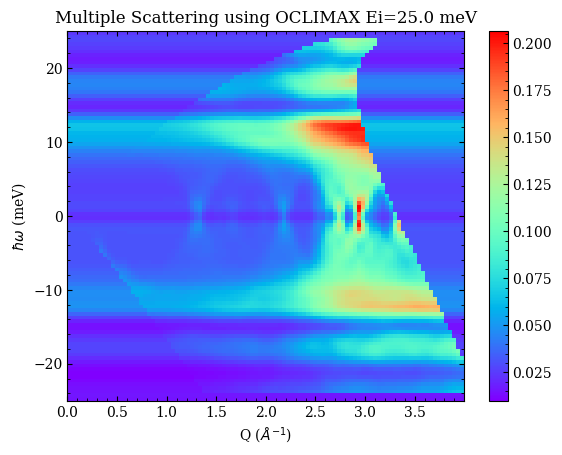

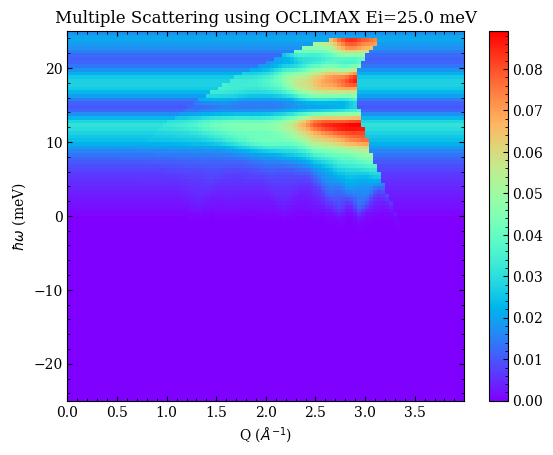

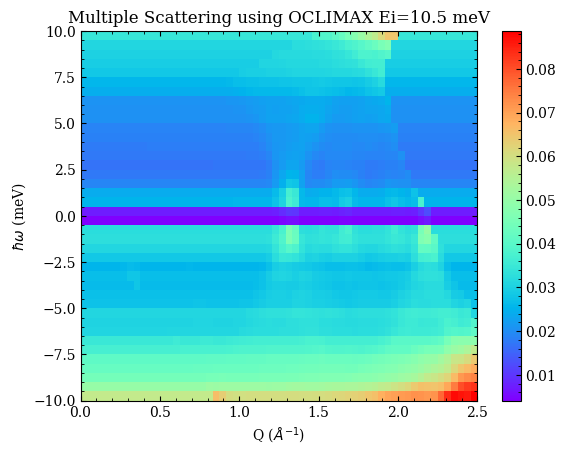

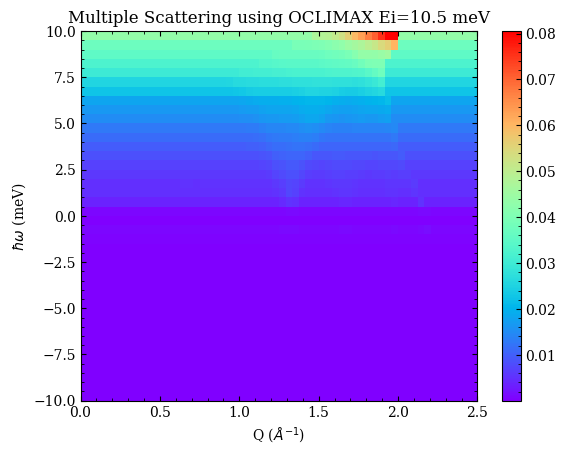

In [8]:
vmax=0.2
A_fixed=4.0*np.pi
multiple_scatter_MD_50_300K, T_val_50_300K,A_val_50_300K = calc_multiple_scattering_OCLIMAX(box_bragg_result_50_300,\
                                                       box_dft_result_50_300,DFT_50meV_MD_full,\
                                                       Qrange_fit=[2.0,3.0],\
                                                       Erange_fit=[15.0,25.0],Ei=50.0,\
                                                       show_plots=False,inA=False,inT=False)
A_fixed = A_val_50_300K
multiple_scatter_MD_50_300K= multiple_scatter_MD_50_300K.clone()
multiple_scatter_MD_50_300K.setErrorSquaredArray(np.copy(MD_abs_bragg_50_300.getErrorSquaredArray()))

multiple_scatter_MD_50_300K = multiple_scatter_MD_50_300K.clone()
multiple_scatter_MD_50_300K*=1.0
bragg_no_mult_50_300K = bnrof.sub_nearest_MD(box_bragg_result_50_300,multiple_scatter_MD_50_300K).clone()

#50meV, 4K
multiple_scatter_MD_50_4K, T_val_50_4K,A_val_50_4K = calc_multiple_scattering_OCLIMAX(box_bragg_result_50_4,\
                                                       box_dft_result_50_4,DFT_50meV_MD_4K_full,Qrange_fit=[2.0,3.0],\
                                                       Erange_fit=[15.0,25.0],Ei=50.0,show_plots=False,inT=False,\
                                                                                     inA = False)
multiple_scatter_MD_50_4K = multiple_scatter_MD_50_4K.clone()
multiple_scatter_MD_50_4K.setErrorSquaredArray(np.copy(MD_abs_bragg_50_4.getErrorSquaredArray()))

multiple_scatter_MD_50_4K*=1.0
bragg_no_mult_50_4K = bnrof.sub_nearest_MD(box_bragg_result_50_4,multiple_scatter_MD_50_4K).clone()

A_fixed=A_fixed
#25meV, 300K
multiple_scatter_MD_25_300K, T_val_25_300K,A_val_25_300K = calc_multiple_scattering_OCLIMAX(box_bragg_result_25_300,\
                                                       box_dft_result_25_300,DFT_25meV_MD_full,\
                                                       Qrange_fit=[2.0,2.5],\
                                                       Erange_fit=[10.0,20.0],Ei=25.0,show_plots=True,inA=False,\
                                                                                           inT=False)
multiple_scatter_MD_25_300K= multiple_scatter_MD_25_300K.clone()
multiple_scatter_MD_25_300K.setErrorSquaredArray(np.copy(MD_abs_bragg_25_300.getErrorSquaredArray()))

multiple_scatter_MD_25_300K = multiple_scatter_MD_25_300K.clone()
multiple_scatter_MD_25_300K*=1.0
bragg_no_mult_25_300K = bnrof.sub_nearest_MD(box_bragg_result_25_300,multiple_scatter_MD_25_300K).clone()

#25meV 4 K
multiple_scatter_MD_25_4K, T_val_25_4K,A_val_25_4K = calc_multiple_scattering_OCLIMAX(box_bragg_result_25_4,\
                                                       box_dft_result_25_4,DFT_25meV_MD_4K_full,
                                                       Qrange_fit=[2.0,2.5],Erange_fit=[10.0,20.0],Ei=25.0,\
                                                       inT=False,inA=False)
multiple_scatter_MD_25_4K= multiple_scatter_MD_25_4K.clone()
multiple_scatter_MD_25_4K.setErrorSquaredArray(np.copy(MD_abs_bragg_25_4.getErrorSquaredArray()))

bragg_no_mult_25_4K = bnrof.sub_nearest_MD(box_bragg_result_25_4,multiple_scatter_MD_25_4K).clone()

#10.5meV, 300K
multiple_scatter_MD_10_150K, T_val_10_150K,A_val_10_150K = calc_multiple_scattering_OCLIMAX(box_bragg_result_10_150,\
                                                       box_dft_result_10_150,DFT_10meV_MD_full,\
                                                       Qrange_fit=[1.5,2.0],\
                                                       Erange_fit=[4,9.0],Ei=10.5,\
                                                        show_plots=True,inT=False,inA=False)
multiple_scatter_MD_10_150K= multiple_scatter_MD_10_150K.clone()
multiple_scatter_MD_10_150K.setErrorSquaredArray(np.copy(MD_abs_bragg_10_4.getErrorSquaredArray()))

multiple_scatter_MD_10_150K*=1.0
bragg_no_mult_10_150K = bnrof.sub_nearest_MD(box_bragg_result_10_150,multiple_scatter_MD_10_150K).clone()

#10.5meV 4 K
multiple_scatter_MD_10_4K, T_val_10_4K,A_val_10_4K = calc_multiple_scattering_OCLIMAX(box_bragg_result_10_4,\
                                                       box_dft_result_10_4,DFT_10meV_MD_4K_full,
                                                       Qrange_fit=[1.5,2.0],Erange_fit=[4.0,9.0],Ei=10.5,\
                                                       inT=False,inA=False)
multiple_scatter_MD_10_4K= multiple_scatter_MD_10_4K.clone()
multiple_scatter_MD_10_4K.setErrorSquaredArray(np.copy(MD_abs_bragg_10_150.getErrorSquaredArray()))

bragg_no_mult_10_4K = bnrof.sub_nearest_MD(box_bragg_result_10_4,multiple_scatter_MD_10_4K).clone()


## Handle deviations of simulation from data by treating them as single-phonon events.

Ultimately the calculation of phonons, while exceptionally good, is imperfect. This is reflected most clearly in the constant-Q cuts. We may 'patch up' these errors using the high Q parts of the highest incident energy scattering.

CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace s

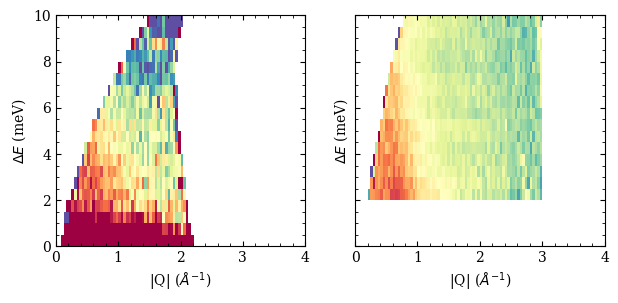

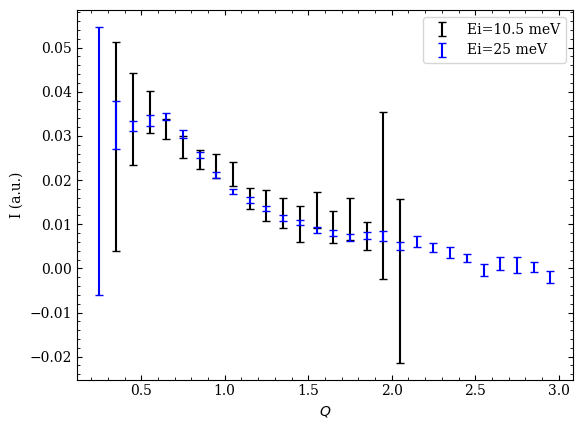

In [108]:
vval =0.05

MD4K_50_qsub = bnrof.sub_highQ_cut(bragg_no_mult_50_4K,[2.0,3.0],[3,35]).clone()
MD300K_50_qsub = bnrof.sub_highQ_cut(bragg_no_mult_50_300K,[2.0,3.0],[3,35]).clone()

Ei50_mag = bnrof.tempsubtract_cut2D(MD4K_50_qsub,MD300K_50_qsub,tLow=4.0,tHigh=300.0).clone()
Ei50_mag_preQsub = bnrof.tempsubtract_cut2D(bragg_no_mult_50_4K,bragg_no_mult_50_300K,tLow=4.0,tHigh=300.0).clone()
#Ei50_mag = sub_highQ_cut(Ei50_mag_preQsub,[3.0,4.0],[3,35]).clone()

qbin25 = [2.5,3.0]
MD4K_25_qsub = bnrof.sub_highQ_cut(bragg_no_mult_25_4K,qbin25,[2,20]).clone()
MD300K_25_qsub = bnrof.sub_highQ_cut(bragg_no_mult_25_300K,qbin25,[2,20]).clone()
Ei25_mag = bnrof.tempsubtract_cut2D(MD4K_25_qsub,MD300K_25_qsub,tLow=4.0,tHigh=300.0).clone()
Ei25_mag_preQsub = bnrof.tempsubtract_cut2D(bragg_no_mult_25_4K,bragg_no_mult_25_300K,tLow=4.0,tHigh=300.0).clone()
Ei25_mag = bnrof.sub_highQ_cut(Ei25_mag_preQsub,qbin25,[2,20]).clone()

#The 10.5 meV data is tough to do this with due to limited Q-range- instead don't do this Q-subtraction 
# We instead use the high-Q cut from the 25 meV data. This is handled slightly differently. 
Ei10_mag_preQsub = bnrof.tempsubtract_cut2D(bragg_no_mult_10_4K,bragg_no_mult_10_150K,tLow=4.0,tHigh=150.0).clone()

e25,i25,err25 = bnrof.cut_MDHisto_powder(Ei25_mag_preQsub,'DeltaE',[2,15,0.25],[2.5,3])
I_interp_25 = scipy.interpolate.interp1d(x=e25,y=i25,bounds_error=False,fill_value='extrapolate')
Err_interp_25 = scipy.interpolate.interp1d(x=e25,y=err25,bounds_error=False,fill_value='extrapolate')

I_10 = np.copy(Ei10_mag_preQsub.getSignalArray())
Err_10 = np.sqrt(np.copy(Ei10_mag_preQsub.getErrorSquaredArray()))
dims = Ei10_mag.getNonIntegratedDimensions()
q10,e10 = mdu.dim2array(dims[0]),mdu.dim2array(dims[1])
for i in range(len(q10)):
    constq_I_interp = I_interp_25(x=e10)
    constq_Err_interp = Err_interp_25(x=e10)
    I_10[i,:]-=0.1*constq_I_interp 
    #A small factor is needed to deal witht he normalization difference between the two measurements
    Err_10[i,:]= np.sqrt(Err_10[i,:]**2 + constq_Err_interp**2)
Ei10_mag = CloneWorkspace(Ei10_mag_preQsub)
Ei10_mag.setSignalArray(I_10)
Ei10_mag.setErrorSquaredArray(Err_10**2)

Ei10_mag_plot = Ei10_mag.clone()
Ei25_mag_plot = Ei25_mag.clone()
bnrof.undo_normalize_MDHisto_event(Ei10_mag_plot)
bnrof.undo_normalize_MDHisto_event(Ei25_mag_plot)

fig,ax=plt.subplots(1,2,subplot_kw={'projection':'mantid'},sharex=True,sharey=True,figsize=(3.54*2,3))
ax[0].pcolormesh(Ei10_mag_plot,vmin=-0.02,vmax=0.05,cmap='Spectral_r')
ax[1].pcolormesh(Ei25_mag_plot,vmin=-0.02,vmax=0.05,cmap='Spectral_r')
ax[0].set_ylim(0,10)
fig.show()
q10,i10,err10 = bnrof.cut_MDHisto_powder(Ei10_mag,'|Q|',[0,3,0.1],[2,5])
q25,i25,err25 = bnrof.cut_MDHisto_powder(Ei25_mag,'|Q|',[0,3,0.1],[2,5])
fig,ax= plt.subplots(1,1)
ax.errorbar(q10,i10,yerr=err10,color='k',capsize=3,ls=' ',label='Ei=10.5 meV')
ax.errorbar(q25,i25,yerr=err25,color='b',capsize=3,ls=' ',label='Ei=25 meV')
ax.set_xlabel("$Q$")
ax.set_ylabel('I (a.u.)')
ax.legend()
fig.show()

CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds


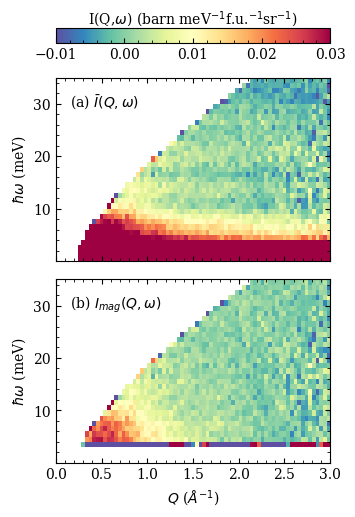

In [109]:
# The plot showing the effect of this subtraction for the Ei=25 meV data is generated here. 
fig,ax = plt.subplots(2,1,figsize=(3.54,5),subplot_kw={'projection':'mantid'},sharex=True,sharey=True)
fig.subplots_adjust(hspace=0.1)
cmap = "Spectral_r"
vmin=-0.01
vmax=0.03
plot_Ei50_presub = Ei50_mag_preQsub.clone()
plot_Ei50_presub = bnrof.undo_normalize_MDHisto_event(plot_Ei50_presub)
plot_Ei50_mag = Ei50_mag.clone()
plot_Ei50_mag = bnrof.undo_normalize_MDHisto_event(plot_Ei50_mag)
clim = 0.03
ax[0].pcolormesh(plot_Ei50_presub,vmin=vmin,vmax=vmax,cmap=cmap,rasterized=True)
ax[1].pcolormesh(plot_Ei50_mag,vmin=vmin,vmax=vmax,cmap=cmap,rasterized=True)
ax[0].set_xlabel('')
ax[1].set_xlabel('$Q$ ($\AA^{-1}$)')
ax[0].set_ylabel('$\hbar\omega$ (meV)')
ax[1].set_ylabel('$\hbar\omega$ (meV)')
ax[0].set_xlim(0,3)
ax[0].set_ylim(0.01,35)
#Add a colorbar
cbar_ax = fig.add_axes([0.125,0.95,0.775,0.03])
cbar_ax.tick_params(labelleft=False,labelbottom=False,labeltop=True)
cmap=plt.get_cmap(cmap)
norm=matplotlib.colors.Normalize(vmin=vmin,vmax=vmax)
cbar_ax.text(0.5,1.55,'I(Q,'+r'$\omega$'+') (barn '+r'meV$^{-1}$'+r'f.u.$^{-1}$'+r'sr$^{-1}$)',
             horizontalalignment='center',verticalalignment='center',transform=cbar_ax.transAxes,fontsize=10)
sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
sm.set_array([])
cb = matplotlib.colorbar.ColorbarBase(cbar_ax,cmap=cmap,norm=norm,orientation='horizontal')

ax[0].text(0.05,0.92,r'(a) $\bar{I}(Q,\omega)$',transform=ax[0].transAxes,
           verticalalignment='top',horizontalalignment='left')
ax[1].text(0.05,0.92,r'(b) $I_{mag}(Q,\omega)$',transform=ax[1].transAxes,
           verticalalignment='top',horizontalalignment='left')

fig.savefig('SEQ_figs/SEQ_Qsub_compare.pdf',bbox_inches='tight',dpi=300)

## Save results for analysis in second notebook.

In [110]:
import shutil
SaveMD(Ei50_mag,'SEQ_Ei50_mag.nxs')
SaveMD(Ei25_mag,'SEQ_Ei25_mag.nxs')
SaveMD(Ei10_mag,'SEQ_Ei10_mag.nxs')
shutil.move('SEQ_Ei50_mag.nxs','Isolated Magnetic NXS Files/SEQ_Ei50_mag.nxs')
shutil.move('SEQ_Ei25_mag.nxs','Isolated Magnetic NXS Files/SEQ_Ei25_mag.nxs')
shutil.move('SEQ_Ei10_mag.nxs','Isolated Magnetic NXS Files/SEQ_Ei10_mag.nxs')


SaveMD-[Notice] SaveMD started
Instrument-[Warning] Saving Instrument with no XML data. If this was instrument data you may not be able to load this data back into Mantid, for fitted/analysed data this warning can be ignored.
SaveMD-[Notice] SaveMD successful, Duration 0.16 seconds
SaveMD-[Notice] SaveMD started
Instrument-[Warning] Saving Instrument with no XML data. If this was instrument data you may not be able to load this data back into Mantid, for fitted/analysed data this warning can be ignored.
SaveMD-[Notice] SaveMD successful, Duration 0.16 seconds
SaveMD-[Notice] SaveMD started
Instrument-[Warning] Saving Instrument with no XML data. If this was instrument data you may not be able to load this data back into Mantid, for fitted/analysed data this warning can be ignored.
SaveMD-[Notice] SaveMD successful, Duration 0.10 seconds


'Isolated Magnetic NXS Files/SEQ_Ei10_mag.nxs'